In [ ]:
! pip3 -q install optax

In [4]:
!git clone https://github.com/VLSF/SNO.git

fatal: destination path 'SNO' already exists and is not an empty directory.


In [1]:
import sys
sys.path.append("/content/SNO")

In [2]:
import jax.numpy as jnp
from jax import random
import optax
import matplotlib.pyplot as plt


%config InlineBackend.figure_format='retina'

In [3]:
from architectures import SNO_2D as vanilla

from datasets import KdV_exact
from functions import Chebyshev, utils

# Write, load and count

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/DL_Final_Project

/content/drive/MyDrive/DL_Final_Project


In [6]:
perm = jnp.load('perms_clear.npy')
pressure = jnp.load('pressures_clear.npy')

print('perm shape:', perm.shape)
print('pressure shape:', pressure.shape)

perm shape: (1317, 64, 64)
pressure shape: (1317, 21, 64, 64)


In [7]:
tr = pressure[0:1316,0:10,:,:].copy()
te = pressure[0:1316,10:20,:,:].copy()

In [8]:
rx = jnp.transpose(tr, axes=(0, 2, 3, 1))
ry = jnp.transpose(te, axes=(0, 2, 3, 1))

In [9]:
rx_train = rx[0:658]
rx_test = rx[658:1316]
ry_train = ry[0:658]
ry_test = ry[658:1316]


In [10]:
params_encoder = vanilla.init_c_network_params([1, 20], random.PRNGKey(11))
params_i = vanilla.init_i_network_params([100, 100, 100, 100], [100, 100, 100, 100], [20, 20, 20, 20], random.PRNGKey(11))
params_decoder = vanilla.init_c_network_params([20, 1], random.PRNGKey(11))
params = [params_encoder, params_i, params_decoder]

In [11]:
vanilla.count_params(params)

661261

In [12]:
vanilla.save_params(params, "chebyshev_33", "vanilla_run_134")
params_ = vanilla.load_params("chebyshev_33", "vanilla_run_134")

In [13]:
print("Same number of layers --", [len(p) == len(p_) for p, p_ in zip(params, params_)])
print("====")

for p, p_ in zip(params, params_):
  for i in range(len(p)):
    print("Layer " + str(i))
    for j in range(len(p[i])):
      print(jnp.all(p[i][j] == p_[i][j]))
    print("====")

Same number of layers -- [True, True, True]
====
Layer 0
True
True
====
Layer 0
True
True
True
True
====
Layer 1
True
True
True
True
====
Layer 2
True
True
True
True
====
Layer 0
True
True
====


# Training I

Initialize network with three layers

In [21]:
params_encoder = vanilla.init_c_network_params([10, 64, 64], random.PRNGKey(11))
params_i = vanilla.init_i_network_params([64, 64, 64, 64], [64, 64, 64, 64], [64, 64, 64, 64], random.PRNGKey(11))
params_decoder = vanilla.init_c_network_params([64, 10], random.PRNGKey(11))
params = [params_encoder, params_i, params_decoder]

vanilla.count_params(params)

828810

Initialize optimizer

In [22]:
sc = optax.exponential_decay(0.001, 5000, 0.5)
optimizer = optax.adam(sc)
opt_state = optimizer.init(params)

In [23]:
train_loss = []
test_loss = []

test_loss.append(vanilla.loss(params, rx_test, ry_test))
train_loss.append(vanilla.loss(params, rx_train, ry_train))

print(train_loss[-1])
print(test_loss[-1])

43988.78225234542
43612.96887531494


In [24]:
for j in range(1000):
  # run in a single batch
  for i in range(41):
    rx_train_batch = rx_train[i:i+1]
    ry_train_batch = ry_train[i:i+1]
    rx_test_batch = rx_test[i:i+1]
    ry_test_batch = ry_test[i:i+1]
    params, opt_state = utils.update_params(params, rx_train_batch, ry_train_batch, optimizer, opt_state, vanilla.loss)
  if (j+1)%50 == 0:
    print('epoch:', j)
    print('test loss:', vanilla.loss(params, rx_test_batch, ry_test_batch))
    print('train loss:', vanilla.loss(params, rx_train_batch, ry_train_batch))
    test_loss.append(vanilla.loss(params, rx_test_batch, ry_test_batch))
    train_loss.append(vanilla.loss(params, rx_train_batch, ry_train_batch))

epoch: 49
test loss: 8487.94370481691
train loss: 5078.084738417321
epoch: 99
test loss: 8266.848257776437
train loss: 4709.1060940645175
epoch: 149
test loss: 7722.416970180303
train loss: 4109.893406122729
epoch: 199
test loss: 7585.711382184661
train loss: 3483.3056079277317
epoch: 249
test loss: 7484.1767149647685
train loss: 3374.614626614715
epoch: 299
test loss: 7480.0513553805695
train loss: 3195.810230549186
epoch: 349
test loss: 7354.386559275778
train loss: 3103.364129095025
epoch: 399
test loss: 7269.333506257925
train loss: 2623.4680969247506
epoch: 449
test loss: 7264.644369650297
train loss: 2591.7625006594303
epoch: 499
test loss: 7259.6114089154125
train loss: 2588.574099577258
epoch: 549
test loss: 7239.731674583213
train loss: 2554.3324050621436
epoch: 599
test loss: 7224.9058611172795
train loss: 2530.148873986835
epoch: 649
test loss: 7218.70958004045
train loss: 2527.1918969728945
epoch: 699
test loss: 7212.5424121596825
train loss: 2544.0638485140826
epoch: 749
t

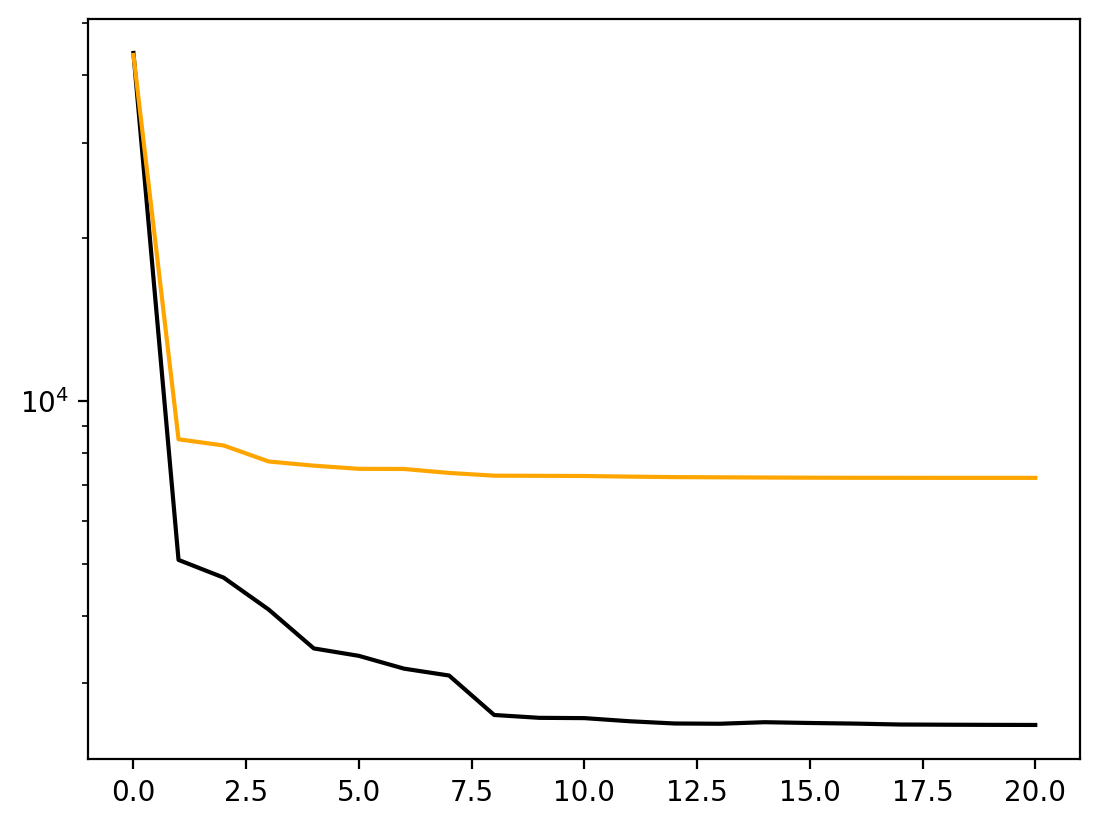

In [25]:
plt.yscale("log")
plt.plot(train_loss, color="black")
plt.plot(test_loss, color="orange");

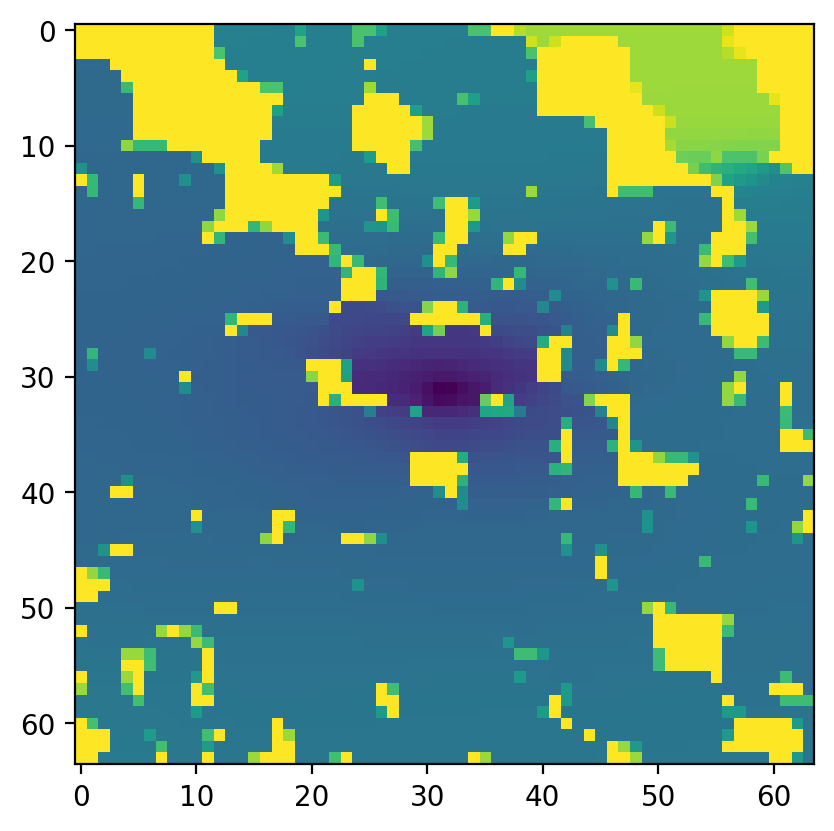

In [27]:
plt.imshow(ry_test[200,:,:,0])

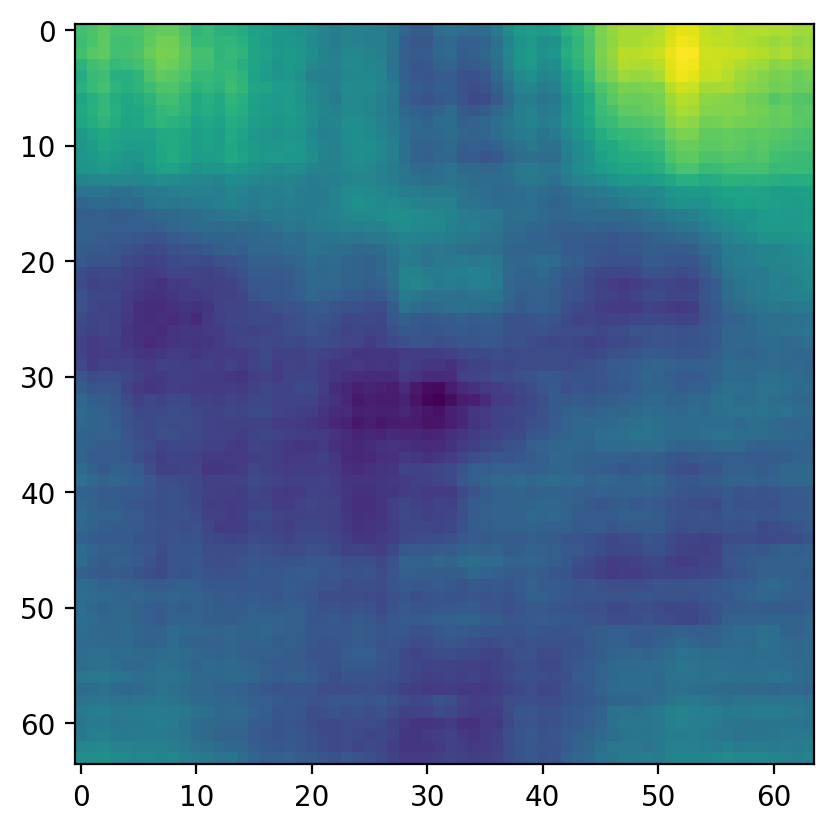

In [28]:
plt.imshow(vanilla.NN(params, rx_test[200])[:,:,0])

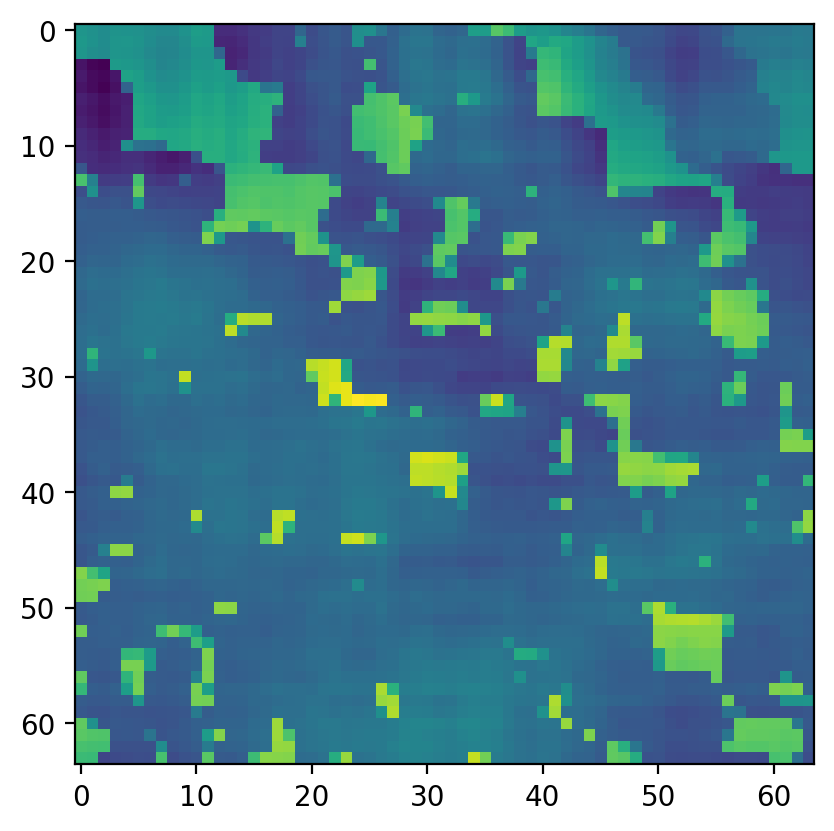

In [39]:
plt.imshow(ry_test[200,:,:,0] - vanilla.NN(params, rx_test[200])[:,:,0])